# Проект "Анализ бизнес-показателей"

## Описание задачи от заказчика

Необходимо: Сформулировать рекомендации для маркетологов по снижению расходов — необходимо отказаться от невыгодных источников трафика и перераспределить бюджет.

Входные данные "некоего сервиса" с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта "некоего сервиса"
- выгрузка всех заказов за этот период
- статистика рекламных расходов



## Определение целей исследования

Рассчитать:

- продуктовые метрики (DAU,WAU,MAU,ASL,Retention Rate, Sessions per user)
- метрики электронной коммерции (средний чек, среднее время до конверсии, LTV)
- маркетинговые метрики в разрезе разных источников трафика (САС, ROMI, расходы )

Используя рассчитанные метрики ответить на вопросы*:
 - Как клиенты пользуются сервисом?
 - Когда клиенты делают первые покупки на сайте?
 - Сколько денег приносит компании каждый клиент?
 - Когда расходы на привлечение клиента окупаются?
 - На какие источники трафика стоит делать упор в рекламной кампании?
 - От каких источников трафика можно отказаться?
 - Какие клиенты наиболее выгодны для компании (исходя из имеюущихся данных)?
 
*Выручка измеряется в условных единицах — у.е.

## Подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import math
import __main__
from scipy import stats as st
import numpy as np
import seaborn as sns


### Импорт функций

In [2]:
# Функция для подсчета количества корзин для гистограммы по правилу Герберта Стерджеса
def bins_num_sturges(column):  
    bins_num = abs(1 + int(math.log2(len(column))))
    if(bins_num) < 200:
        return bins_num
    else:
        return 200
    
# Функция для подсчета ширины корзины для гистограммы по правилу Фридмана-Дьякониса     
def bins_num_fr_dk(column): 
    Q1 = column.quantile(0.25) #находим первый квартиль
    Q3 = column.quantile(0.75) #находим третий квартиль
    IQR = Q3 - Q1 #находим межквартильный размах
    bins_num = int(abs(2 * IQR * len(column)**(-1/3)))
    print(bins_num)
    if bins_num < 1:
        return 1
    elif bins_num < 200:
        return bins_num
    else:
        return 200
    
# Функция для отрисовки гистограммы с возможностью выбора размера фигуры и способа подсчета корзин 
def draw_hist(dataframe,column,way_bins,title,xsize=6,ysize = 4): 
    if (way_bins == 'S'):
        dataframe.hist(
                column,
                bins =  bins_num_sturges(dataframe[column]),
                figsize=(xsize,ysize)
                )          
    elif (way_bins == 'FD'):
        dataframe.hist(
                column,
                bins =  bins_num_fr_dk(dataframe[column]),
                figsize=(xsize,ysize)
              )    
    else:
        way_bins = pd.to_numeric(way_bins) #гистограмма с произвольным числом корзин
        dataframe.hist(
                column,
                bins =  way_bins,
                figsize=(xsize,ysize)
              )
    plt.title(title)
    plt.show() 

# Функция для отрисовки boxplot
def draw_boxplot(dataframe,column):
    dataframe.boxplot(column)
    return plt.show()

# Находим границы "усов"
def find_moustache(column): 
    Q1,Q3 = column.quantile([.25,.75]) #находим первый и третий квартили
    IQR = Q3 - Q1 #находим межквартильный размах
    min_val = Q1 - (IQR * 1.5) 
    max_val = Q3 + (IQR * 1.5)
    
    if(min_val < column.min()):
        if(max_val > column.max()):
            return column.min(),column.max()
        else:
            return column.min(),max_val         
    elif(max_val > column.max()):
            return min_val,column.max()
    else:
        return min_val,max_val
           
# Функция для подсчет количества данных находящимися за пределами "усов" и нахождение процента от общих данных
def num_normalized_data_info(dataframe,column): 
    try:
        min_val,max_val = find_moustache(dataframe[column])
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    print('Количество данных из столбца ',column, ', которые считаем выбросами:'
      ,dataframe[((dataframe[column] > max_val) | (dataframe[column] < min_val)) & ~dataframe[column].isna()][column].count()
      ,', процент от общего числа: {:.1%}'
      .format(
          dataframe[(dataframe[column] > max_val) | (dataframe[column] < min_val)][column].count()/dataframe[column].count()
          )
    ) 

# Отбор данных без выбросов 
def num_normalized_data(dataframe,column,with_nan = True): 
    try:
        min_val,max_val = find_moustache(dataframe[column])
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    if (with_nan):
        return dataframe[((dataframe[column] <= max_val) & (dataframe[column] >= min_val)) | dataframe[column].isna()] 
    else:
        return dataframe[(dataframe[column] <= max_val) & (dataframe[column] >= min_val)]

# Проверяем, что в финальной выборке нет выбросов
def num_normalized_data_check(dataframe,column,dataframe2): 
    try:
        min_val,max_val = find_moustache(dataframe2[column])# квантили и "усы" берем из изначальных данных
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    
    return print('Количество выбросов в столбце ',column, ' в итоговой выборке:',dataframe[((dataframe[column] > max_val) | (dataframe[column] < min_val)) & (~dataframe[column].isna())][column].count());
    

# Поиск дублей с учетом регистра
def reg_duplicates_alert(dataframe,column):
    if(len(dataframe[column].unique()) == len(dataframe[column])):
        return print('Дублей в столбце',column, 'нет.')
    else:
        return print('Дубли,в столбце',column, 'есть.')

### Импорт данных

Испортируем данные и проверим на корректность имена столбцов

In [3]:
datasets = ['visits_log','orders_log','costs']

for each in datasets:
    setattr(__main__, each, pd.read_csv('/datasets/{}.csv'.format(each)))
    display(eval(each).head(3))
    print()
    print(eval(each).columns)


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527



Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844



Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53



Index(['source_id', 'dt', 'costs'], dtype='object')


В таблицах "orders_log" и " visits_log" есть заглавные буквы и пробелы в названиях столбцов - это нужно исправить

In [4]:
visits_log.columns = ['device','end_ts','source_id','start_ts','uid']
orders_log.columns = ['buy_ts','revenue','uid']

for each in datasets:
    print(eval(each).columns)
    print()

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Index(['source_id', 'dt', 'costs'], dtype='object')



Nеперь названия столбцов корректны во всех таблицах.

### Обработка пропусков

Проверим, есть ли пропуски в данных.

In [5]:
for each in datasets:
    print("Таблица",each)
    for column in eval(each).columns.tolist():
        print('Количество NaN в столбце',column,': ', eval(each)[column].isna().sum())
    print()

Таблица visits_log
Количество NaN в столбце device :  0
Количество NaN в столбце end_ts :  0
Количество NaN в столбце source_id :  0
Количество NaN в столбце start_ts :  0
Количество NaN в столбце uid :  0

Таблица orders_log
Количество NaN в столбце buy_ts :  0
Количество NaN в столбце revenue :  0
Количество NaN в столбце uid :  0

Таблица costs
Количество NaN в столбце source_id :  0
Количество NaN в столбце dt :  0
Количество NaN в столбце costs :  0



Пропусков в данных нет (спасибо за это).

### Поиск и обработка дублей и ошибок в данных

Проверим таблицы на дубли в строках и на наличие отрицательных значений.
Также визуально проверим, все ли в порядке со значениями в столбце "device" таблицы "visits_log" и столбце "source_id" таблицы "costs" 

In [6]:
for each in datasets:
    print('Дублей в таблице: ', each,':',eval(each).duplicated().sum())
print()
exceptions = []# список для записи столбцов, в которых не удалось проверить на отрицательные значения
print('Поиск отрицательных значений')
for each in datasets:
    for column in eval(each).columns.values.tolist():  
        try:
            data = eval(each)[eval(each)[column] < 0]
            if len(data) != 0:
                print('Отрицательные значения в таблице: \r\n',each)
        except:
            exceptions.append(column)         
print('Не удалось найти отрицательные значения в столбцах: ',exceptions)
print()

print('Данные в столбце device таблицы visits_log')    
display(visits_log['device'].value_counts())
print('Данные в столбце source_id таблицы costs')    
display(costs['source_id'].value_counts())

Дублей в таблице:  visits_log : 0
Дублей в таблице:  orders_log : 0
Дублей в таблице:  costs : 0

Поиск отрицательных значений
Не удалось найти отрицательные значения в столбцах:  ['device', 'end_ts', 'start_ts', 'buy_ts', 'dt']

Данные в столбце device таблицы visits_log


desktop    262567
touch       96833
Name: device, dtype: int64

Данные в столбце source_id таблицы costs


5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

С данными все в порядке. 
Интересно, что на каждый из существующих рекламных источников приходится одинакое количество (не объем!) расходов.  

### Преобразование типов данных

Проверим типы данных в столбцах таблицы.

In [7]:
for each in datasets:
    print("Таблица",each)
    eval(each).info()
    print()

Таблица visits_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Таблица orders_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Таблица costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB



Необходимо изменить типы данных:
- в столбцах "end_ts" и "start_ts" в таблице "visits_log" на datetime  
- в столбце "buy_ts"  в таблице "orders_log" на datetime 
- в стоблце "dt" в таблице "costs" на datetime

In [8]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

for each in datasets:
    print("Таблица",each)
    eval(each).info()
    print()

Таблица visits_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB

Таблица orders_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

Таблица costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usa

In [9]:
display(costs['source_id'].value_counts())
display(costs.groupby('source_id').agg({'costs':'sum'}))

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


### Вывод

Данные в порядке, пропусков, дублей и ошибок нет. Типы данных приведены к корректным. Теперь можно переходить к расчетам.

## Расчет метрик

### Расчет продуктовых метрик

Рассчитаем DAU,MAU,WAU

In [10]:
visits_log['session_year']  = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_week']  = visits_log['start_ts'].dt.week
visits_log['session_date'] = visits_log['start_ts'].dt.date

display(visits_log.head())

mau_total = (
    visits_log.groupby(['session_year','session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)
dau_total = (
    visits_log.groupby(['session_month','session_date'])
    .agg({'uid': 'nunique'})
    .mean()
)
wau_total = (
    visits_log.groupby(['session_year','session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

print('За весь период:')
print('Среднее количество уникальных пользователей в день равно:',dau_total)
print('Среднее количество уникальных пользователей в неделю равно:',wau_total)
print('Среднее количество уникальных пользователей в месяц равно:',mau_total)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


За весь период:
Среднее количество уникальных пользователей в день равно: uid    907.991758
dtype: float64
Среднее количество уникальных пользователей в неделю равно: uid    5716.245283
dtype: float64
Среднее количество уникальных пользователей в месяц равно: uid    23228.416667
dtype: float64


Посмотрим, как изменялись метрики со временем. Что бы график числа уникальных посетителей в день был читаемым усредним помесячно количество уникальных посетителей в день.

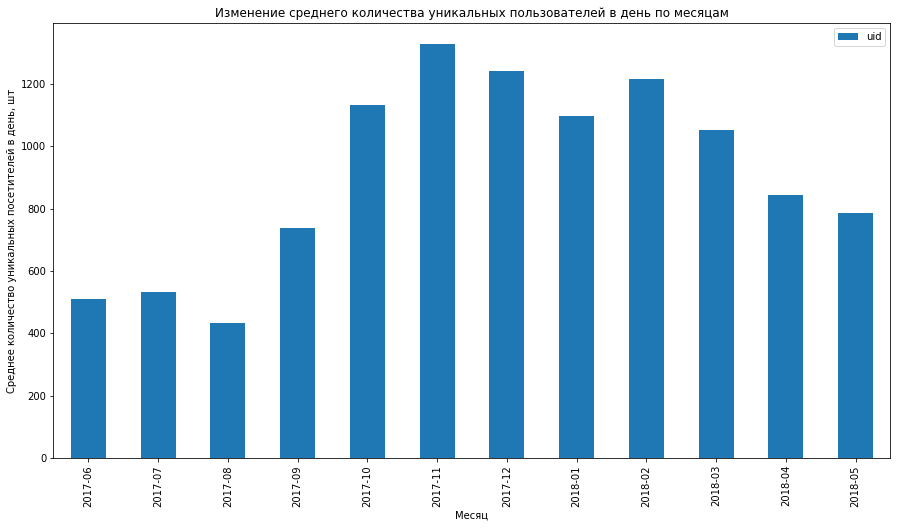

In [11]:
dau_month = (
    visits_log.groupby(['session_date'])
    .agg({'uid': 'nunique'})
    
).reset_index()
dau_month['session_date'] = [x[:7] for x in dau_month['session_date'].astype(str)]
dau_month = dau_month.pivot_table(index = 'session_date',values = 'uid',aggfunc = 'mean').reset_index()
dau_month.plot(
    x='session_date',
    y='uid',
    kind = 'bar',
    figsize = (15,8)
)
plt.title('Изменение среднего количества уникальных пользователей в день по месяцам')
plt.ylabel('Среднее количество уникальных посетителей в день, шт')
plt.xlabel('Месяц')
plt.show()


Наибольшее количество уникальных пользователей в день, усредненноое по месяцам пришлось на конец 2017 года - начало 2018 года (октябрь, ноябрь, декабрь 2017 и январь 2018). Максимальное среднее количество уникальных пользователей в день в ноябре 2017 - ~1250 человек, минимальное в агусте - ~420 человек.

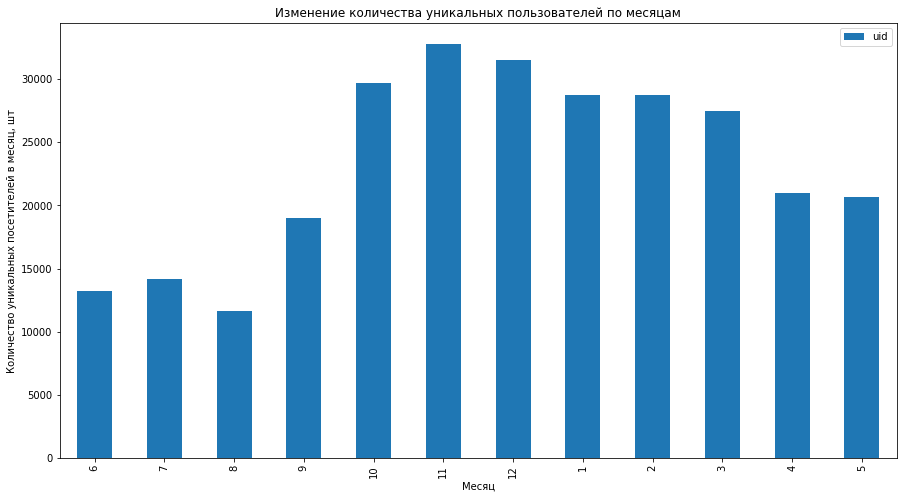

In [12]:
mau_year = (
    visits_log.groupby(['session_year','session_month'])
    .agg({'uid': 'nunique'})
    
).reset_index()
mau_year.plot(
    x='session_month',
    y='uid',
    kind = 'bar',
    figsize = (15,8)
)
plt.title('Изменение количества уникальных пользователей по месяцам')
plt.ylabel('Количество уникальных посетителей в месяц, шт')
plt.xlabel('Месяц')
plt.show()


Динамика изменения количества уникальных пользователей в день практически идентична динамике изменения среднего количества в месяц.
Наибольшее количество уникальных пользователей в месяц пришлось на конец 2017 года - начало 2018 года (октябрь, ноябрь, декабрь 2017 и январь 2018). Максимальное среднее количество уникальных пользователей в месяц в ноябре 2017 - ~32000 человек, минимальное в агусте - ~11000 человек.

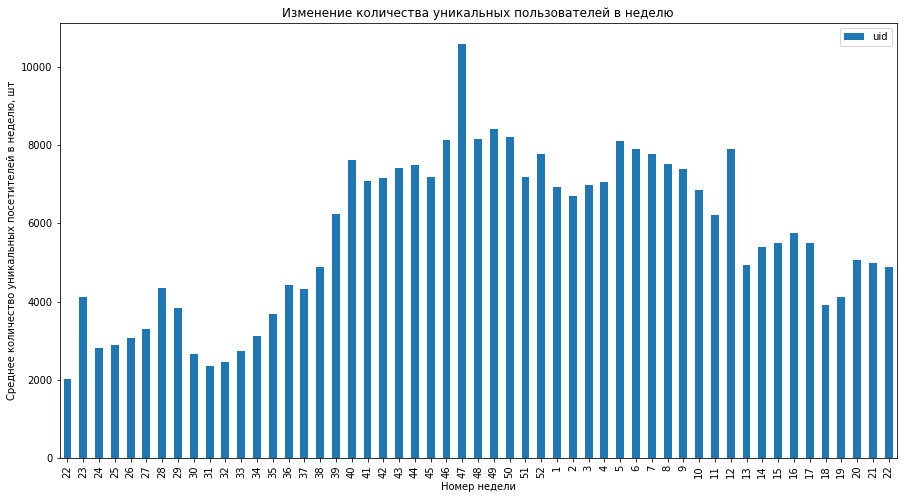

In [13]:
wau_year = (
    visits_log.groupby(['session_year','session_week'])
    .agg({'uid': 'nunique'})
    
).reset_index()
wau_year.plot(
    x='session_week',
    y='uid',
    kind = 'bar',
    figsize = (15,8)
)
plt.title('Изменение количества уникальных пользователей в неделю')
plt.ylabel('Среднее количество уникальных посетителей в неделю, шт')
plt.xlabel('Номер недели')
plt.show()


22 неделя дважды попала в график, т.к. это разные недели: первая это 22 неделя из 2017 года, а последняя на графике 22 неделя из 2018 года.

Динамика изменения уникального количества посетителей в неделю также совпадает с динамиковй двух предыдущих графиков. Также можно заметить выбросы на 47 неделе (ноябрь) 2017 года и 12 неделе 2018 года (вторая половина февраля). Вероятно ноябрьский связан с интересом пользователей к новогодним мероприятиям, а февральский связан с праздниками 23 февраля и 8 марта.

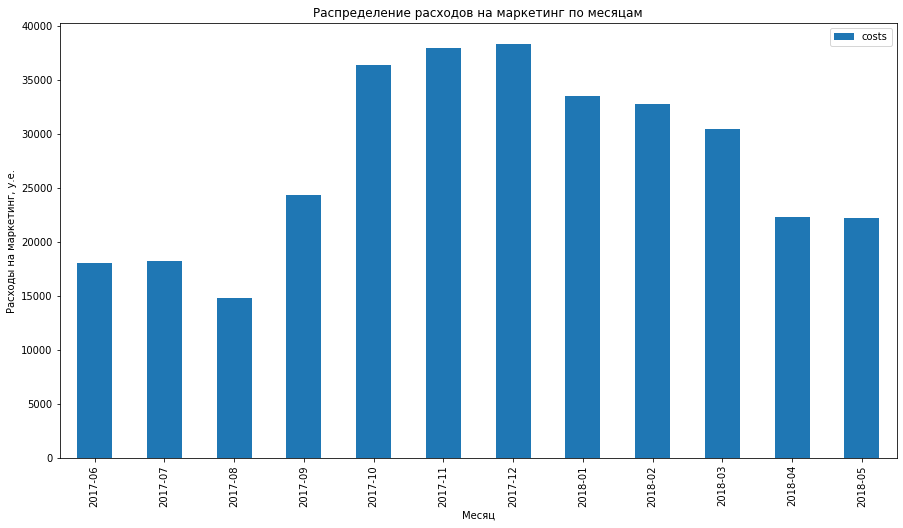

In [14]:
costs_per_month = costs
costs_per_month['dt_month'] = [x[:7] for x in costs_per_month['dt'].astype(str)]
costs_per_month = costs_per_month.groupby('dt_month').agg({'costs':'sum'}).reset_index()
costs_per_month.plot(
    x='dt_month',
    y='costs',
    kind = 'bar',
    figsize = (15,8)
)
plt.title('Распределение расходов на маркетинг по месяцам')
plt.ylabel('Расходы на маркетинг, у.е.')
plt.xlabel('Месяц')
plt.show()


Закономерно, что график расходов на маркетинг практически совпадает с графиком изменения числа уникальных пользователей. Очень сильную прямую связь подтверждает и коэффициент корреляции - 0.97. Это означает, что одним (и очень весомым) из факторов, влияющих на количество уникальных пользователей являются расходы на привлечение клиентов. Далее рассмотрим распределение расходов по источникам, а пока определим, сколько раз в день в среднем пользователь заходит на сайт.

In [15]:
corr_table = pd.merge(dau_month,costs_per_month,left_on = 'session_date',right_on = 'dt_month')
display(corr_table.corr())

,uid,costs
uid,1.000000,0.971664
costs,0.971664,1.000000


Среднее количество сессий в день на пользователя равно:  1.0874136559064957


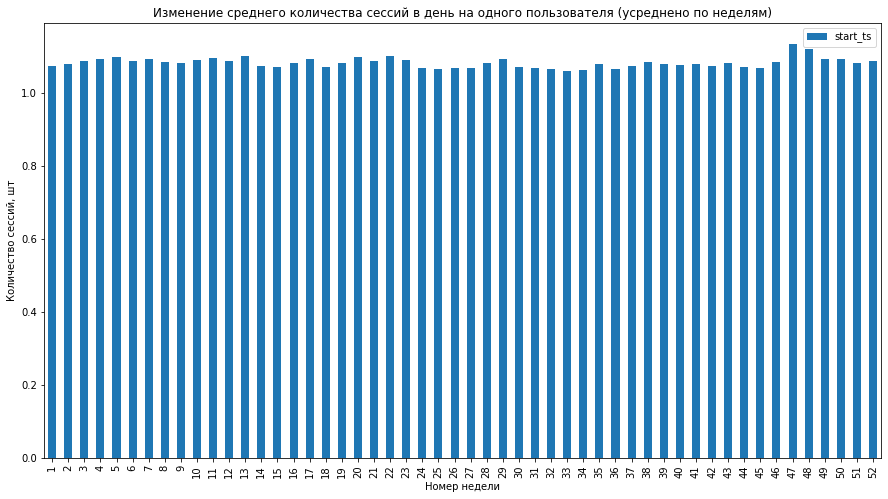

In [16]:
num_sess_per_day = visits_log.groupby(['uid','session_date']).agg({'start_ts':'count'}).reset_index()

print('Среднее количество сессий в день на пользователя равно: ',num_sess_per_day['start_ts'].mean())
num_sess_per_day['session_month']  = pd.to_datetime(num_sess_per_day['session_date']).dt.week
num_sess_per_day_pivot = num_sess_per_day.pivot_table(index = 'session_month',values = 'start_ts',aggfunc = 'mean').reset_index()



num_sess_per_day_pivot.plot(
    x='session_month',
    y='start_ts',
    kind = 'bar',
    figsize = (15,8)
)
plt.title('Изменение среднего количества сессий в день на одного пользователя (усреднено по неделям)')
plt.ylabel('Количество сессий, шт')
plt.xlabel('Номер недели')
plt.show()






Из графика видно, что на протяжении всего периода наблюдений (июнь 2017 - май 2018) среднее количество сессий в день на одного пользователя практически не изменяется и равно 1.09 сессии в день. Это говорит о том, что, как правило, пользователь заходит один раз в день на сайт "некоего сервиса". 

С одной стороны это может быть плохо - пользователь всего один раз в день заходит на сайт. Особенно, если время его сессии короткое (далее проверим это). 

С другой стороны это может говорить о том, что сайт понятный и удобный и пользователю действительно достаточно один раз в день посмотреть необходимую информацию.

Точнее можно будет сказать после анализа метрики Retention Rate - если пользователи возвращаются, значит сайт, скорее всего, действительно удобный.   

Посмотрим, сколько в среднем времени пользователи (ASL) проводят на сайте. 

In [17]:
visits_log['session_duration_sec'] = (
    visits_log['end_ts'] - visits_log['start_ts']
).dt.seconds
display(visits_log.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


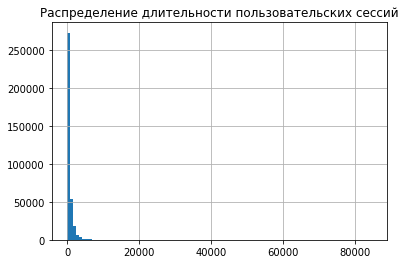

In [18]:
draw_hist(visits_log,'session_duration_sec','100','Распределение длительности пользовательских сессий')

Есть сессии по 80000 секунд (более 22 часов). Это явно выбросы, поэтому удалим их и построим гистограмму снова. 

Количество данных из столбца  session_duration_sec , которые считаем выбросами: 24658 , процент от общего числа: 6.9%
Количество выбросов в столбце  session_duration_sec  в итоговой выборке: 0


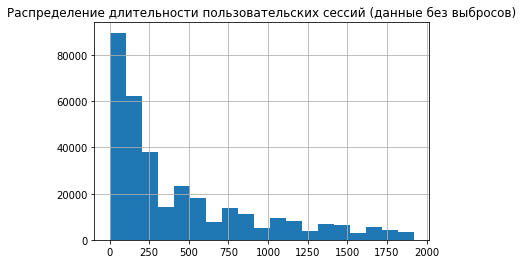

In [19]:
num_normalized_data_info(visits_log,'session_duration_sec')
visits_log_normalized = num_normalized_data(visits_log,'session_duration_sec')
num_normalized_data_check(visits_log_normalized,'session_duration_sec',visits_log)
draw_hist(visits_log_normalized,'session_duration_sec','S','Распределение длительности пользовательских сессий (данные без выбросов)')

Распределение и до очистки от выбросов и после очистки явно не нормальное и похоже на распределение Пуассона. 
Поэтому за среднее возьмем моду выборки. 

In [20]:
print('Мода')
print('Мода неочищенных данных',visits_log['session_duration_sec'].mode())
print('Мода неочищенных данных',visits_log_normalized['session_duration_sec'].mode())
print()
print('Медиана')
print('Медиана неочищенных данных',visits_log['session_duration_sec'].median())
print('Медиана данных без выбросов',visits_log_normalized['session_duration_sec'].median())


Мода
Мода неочищенных данных 0    60
dtype: int64
Мода неочищенных данных 0    60
dtype: int64

Медиана
Медиана неочищенных данных 300.0
Медиана данных без выбросов 240.0


Медиана больше моды в 4-5 раз, а мода даже после очистки данных от выбросов не изменилась и равна 60 секундам. Это говорит о том, что мы выбрали верный способ определения средней длительности сессии. 

Пользователи, в среднем, проводят 60 секунд на сайте - это не так уж и много на первый взгляд. После анализа Retention Rate можно будет сказать, примлимое ли это время сессии или необходимо что-то изменить на сайте.  

Посчитаем Retention Rate и проанализируем изменение этого показателя по lifetime по месяцам с помощью тепловой карты. Т.к. для недель получится большая таблица (52 недели в столбцах для lifetime), то выводить сводную таблицу и тепловую карту для этих недельных когорт не будем.

Найдем средний Retention Rate для месячных когорт на второй месяц, что бы посмотреть, сколько пользователей возвращаются на следующий месяц после первого посещения сайта. Мерой среднего будем считать медиану, т.к. есть совсем "молодые" когорты, которые в данном случае можно считать выбросом и их значения Retention Rate могут сместить среднее по выборке. 


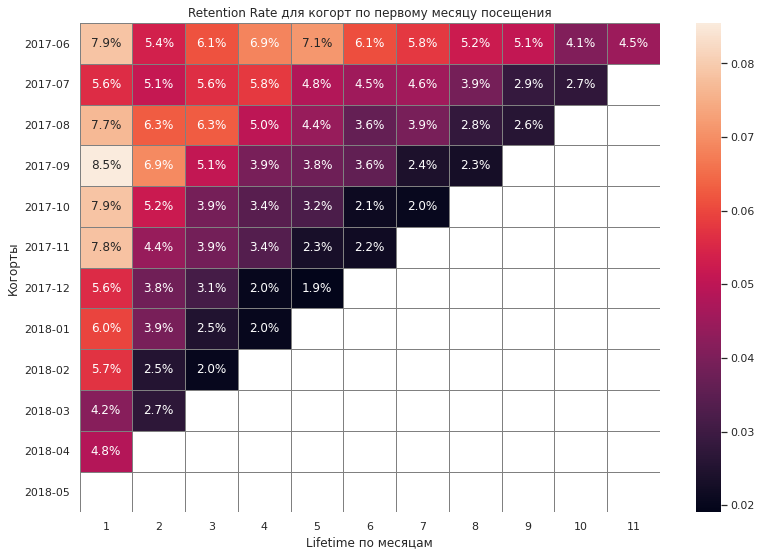

Медиана значения Retention Rate для месячных когорт на 2 месяц: 0.05971534653465346


In [21]:
visits_log['session_date'] = pd.to_datetime(visits_log['session_date'])

#для удобства оставляем только необходимые для анализа столбцы
cohort_visits = visits_log[['device','source_id','uid','session_date','start_ts']]

#находим дату первой сессии 
first_activity_date = cohort_visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
cohort_visits = cohort_visits.join(first_activity_date, on='uid')

cohort_visits['first_activity_month'] = cohort_visits['first_activity_date'].astype(
    'datetime64[M]'
)
cohort_visits['activity_month'] = cohort_visits['start_ts'].astype(
    'datetime64[M]'
)

#Находим lifetime по месяцам
cohort_visits['cohort_month_lifetime'] = (cohort_visits['activity_month'] - cohort_visits['first_activity_month'])
cohort_visits['cohort_month_lifetime'] = (cohort_visits['cohort_month_lifetime'] / np.timedelta64(1, 'M')).round()
cohort_visits['cohort_month_lifetime'] = cohort_visits['cohort_month_lifetime'].astype('int')

'''cohort_visits['session_date'] = [x[:10] for x in cohort_visits['session_date'].astype(str)]
cohort_visits['first_activity_date'] = [x[:10] for x in cohort_visits['first_activity_date'].astype(str)]
#cohort_visits['first_activity_month'] = [x[:10] for x in cohort_visits['first_activity_month'].astype(str)]
cohort_visits['first_activity_month'] = [x[:7] for x in cohort_visits['first_activity_date'].astype(str)]
display(cohort_visits.head())'''

cohort_visits['first_activity_month'] = [x[:7] for x in cohort_visits['first_activity_month'].astype(str)]



#Считаем Retention Rate по месяцам
cohorts_month = cohort_visits.groupby(['first_activity_month','cohort_month_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count_month = cohorts_month[cohorts_month['cohort_month_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count_month = initial_users_count_month.rename(columns={'uid':'cohort_month_users'}) 
cohorts_month = pd.merge(cohorts_month,initial_users_count_month,on='first_activity_month') 
cohorts_month['retention_month'] = cohorts_month['uid']/cohorts_month['cohort_month_users'] 
retention_pivot_month = cohorts_month.pivot_table(
    index='first_activity_month',
    columns='cohort_month_lifetime',
    values='retention_month',
    aggfunc='sum'
)
#display(retention_pivot_month.head())

#рисуем тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate для когорт по первому месяцу посещения')
sns.heatmap(retention_pivot_month.loc[:,[1,2,3,4,5,6,7,8,9,10,11]], annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('Lifetime по месяцам')
plt.ylabel('Когорты')
plt.show()


print('Медиана значения Retention Rate для месячных когорт на 2 месяц:',retention_pivot_month[1].median())

Из всех пользоватей июня 2017 года на следующий месяц повторно зашли на сайт только 5,9% пользователей.

#### Вывод

Исходя из полученных данных по рассчитанным метрикам есть три варианта для оценки ситуации:

1) С сайтом что-то не так: несмотря на хорошие показатели посещаемости сайта (среднее количество уникальных пользователей в день равно 908, в неделю 5717, в месяц 23229) пользователи в среднем проводят на сайте всего по 1 минуте и, обычно, заходят на сайт не более 1 раза в день; из всех пользователей за месяц, в среднем, всего лишь 5,5% или 1278 пользователей возвращаются на сайт на следующий месяц. 

2) Что-то не так с определением uid пользователей. Например, идентификаторы сбрасываются при каком-то условии и тогда у нас завышены показатели посещаемости, но Retention Rate может быть больше. После выполнения задачи будет сформирована рекомендация обратиться к разработчикам компании для проверки корректности присвоения "uid" пользователям. 

3) Пользователи могли определиться с выбором до захода на сайт, поэтому им не нужно много времени на совершение покупки.

### Расчет метрик электронной коммерции

 Найдем среднее время до конверсии (из посещения сайта в покупку).

Для начала найдем дату первой покупки и добавим все необходимые для расчета столбцы в таблицу. Далее найдем разницу между датой первой покупки и датой. Мерой разницы возьмем секунду и при необходимости переведем другую, например в часы или дни.    

In [22]:
#находим дату первой покупки 
first_buy_ts = orders_log.groupby(['uid'])['buy_ts'].min()
first_buy_ts.name = 'first_buy_ts'

ecom_metrics = visits_log[['device','source_id','uid','session_date']].join(first_buy_ts, on='uid')

#присоеденим столбец с датой первой сессии
ecom_metrics=ecom_metrics.join(first_activity_date, on='uid')

ecom_metrics['time_to_conversion'] = (ecom_metrics['first_buy_ts'] - ecom_metrics['first_activity_date']).dt.seconds

display(ecom_metrics.head())


,device,source_id,uid,session_date,first_buy_ts,first_activity_date,time_to_conversion
0,touch,4,16879256277535980062,2017-12-20,NaT,2017-12-20 17:20:00,NaN
1,desktop,2,104060357244891740,2018-02-19,NaT,2018-02-19 16:53:00,NaN
2,touch,5,7459035603376831527,2017-07-01,NaT,2017-07-01 01:54:00,NaN
3,desktop,9,16174680259334210214,2018-05-20,2018-03-09 20:25:00,2018-03-09 20:05:00,1200.0
4,desktop,3,9969694820036681168,2017-12-27,NaT,2017-12-27 14:06:00,NaN


Для определения меры среднего построим график распределения. В данном случае очищать данные от выбросов не будем, т.к. можем потерять важную информацию (например, выбросы с неожиданными значениями). 

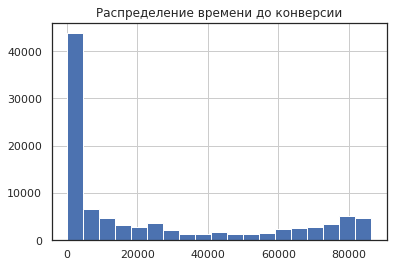

In [23]:
draw_hist(ecom_metrics,'time_to_conversion','S','Распределение времени до конверсии')


Распределение не похоже на нормальное, поэтому мерой среднего выберем медиану, т.к. она более устойчива к выбросам.

In [24]:
print(ecom_metrics['time_to_conversion'].median())

7920.0


Судя по медиане, в среднем, через ~15 часов после первого посещения пользователи совершают покупку.  

Далее найдем среднее количество покупок на одного покупателя за 6 месяцев. Для этого используем когортный анализ, построим тепловую карту и найдем среднее значение для 6 месяца lifetime 

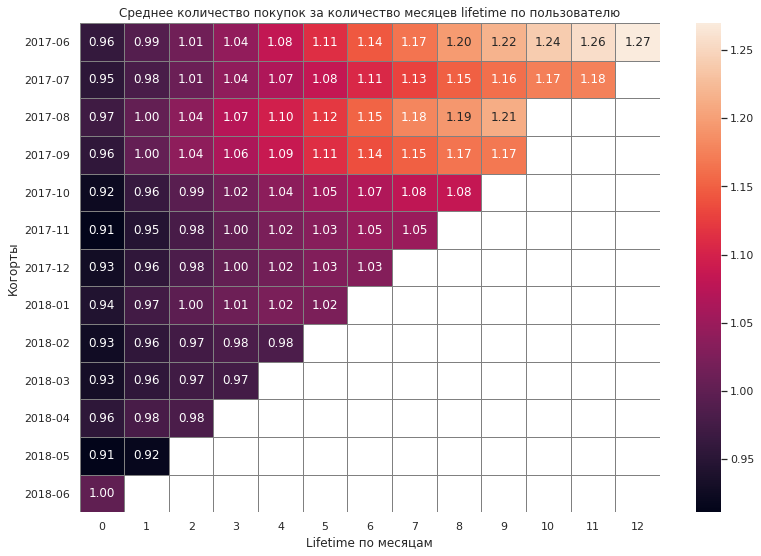

Среднее количество покупок на пользователя на 6-й месяц: 1.0711863637402352


In [25]:
orders_log = orders_log.join(first_buy_ts, on='uid')
orders_log['buy_month'] = [x[:7] for x in orders_log['first_buy_ts'].astype(str)]

cohort_sizes = (
    orders_log.groupby('buy_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['buy_month', 'n_buyers']

average_num_orders_per_user = orders_log

#Находим lifetime по месяцам
average_num_orders_per_user['cohort_month_lifetime'] = (
    average_num_orders_per_user['buy_ts'] - average_num_orders_per_user['first_buy_ts']
)
average_num_orders_per_user['cohort_month_lifetime'] = (
    average_num_orders_per_user['cohort_month_lifetime'] / np.timedelta64(1, 'M')
).round()
average_num_orders_per_user['cohort_month_lifetime'] = average_num_orders_per_user['cohort_month_lifetime'].astype('int')



#находим среднее количество покупок на пользователя 
num_orders = average_num_orders_per_user.groupby(['buy_month','cohort_month_lifetime']).agg(
    {'first_buy_ts':'nunique'}
).reset_index()

num_orders = pd.merge(num_orders,cohort_sizes,on='buy_month')

num_orders.columns = ['buy_month','cohort_month_lifetime','n_orders','n_users']

num_orders['orders_per_user'] = (
    num_orders['n_orders'] / num_orders['n_users']
)

cohort_orders_per_user =  num_orders.pivot_table(
    index = 'buy_month',
    columns = 'cohort_month_lifetime',
    values = 'orders_per_user',
    aggfunc = 'mean'
).cumsum(axis=1)

#рисуем тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cреднее количество покупок за количество месяцев lifetime по пользователю')
sns.heatmap(cohort_orders_per_user, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Lifetime по месяцам')
plt.ylabel('Когорты')
plt.show()

print('Среднее количество покупок на пользователя на 6-й месяц:',cohort_orders_per_user[5].mean())



В среднем, пользователь за 6 месяцев после первого посещения сайта совершает 1,07 покупки - совсем не много.

Проанализируем, как изменяется средний чек по месяцам.

Средний чек за весь период равен:  5.19


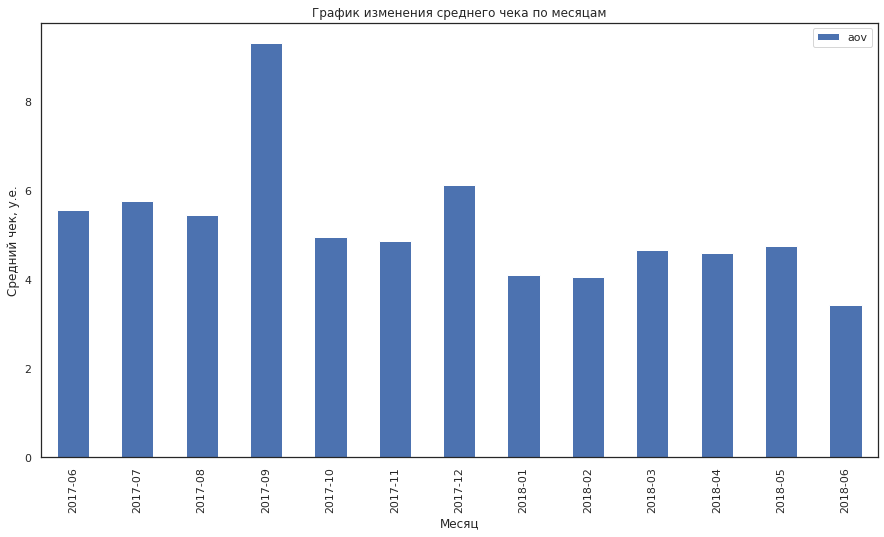

In [26]:

aov_pivot = orders_log.groupby('buy_month').agg({'revenue':'sum','buy_ts':'nunique'}).reset_index()
aov_pivot['aov'] = aov_pivot['revenue']/aov_pivot['buy_ts']

print('Средний чек за весь период равен: ',aov_pivot['aov'].mean().round(2))
aov_pivot.plot(
    x = 'buy_month',
    y = 'aov',
    kind = 'bar',
    figsize = (15,8)
)

plt.title('График изменения среднего чека по месяцам')
plt.ylabel('Средний чек, у.е.')
plt.xlabel('Месяц')
plt.show()

Из графика видно, что самый высокий средний чек в сентябре 2017 и равен ~9,3 у.е., а также, что средний чек со временем падает.

Средний чек за весь период составляет: 5,19 у.е

Далее проанализируем, как меняется LTV со временем для когорт "возрастом" не менее 6 месяцев. В расчетах берем маржинальность за 100%.  

,buy_month,n_buyers,first_order_month,orders_month,revenue,age
0,2017-06,2023,2017-06-01,2017-06-01,9557.49,0
1,2017-06,2023,2017-06-01,2017-07-01,981.82,1
2,2017-06,2023,2017-06-01,2017-08-01,885.34,2
3,2017-06,2023,2017-06-01,2017-09-01,1931.30,3
4,2017-06,2023,2017-06-01,2017-10-01,2068.58,4
...,...,...,...,...,...,...
58,2017-12,4383,2017-12-01,2018-01-01,1141.22,1
59,2017-12,4383,2017-12-01,2018-02-01,4054.70,2
60,2017-12,4383,2017-12-01,2018-03-01,4669.10,3
61,2017-12,4383,2017-12-01,2018-04-01,1371.57,4


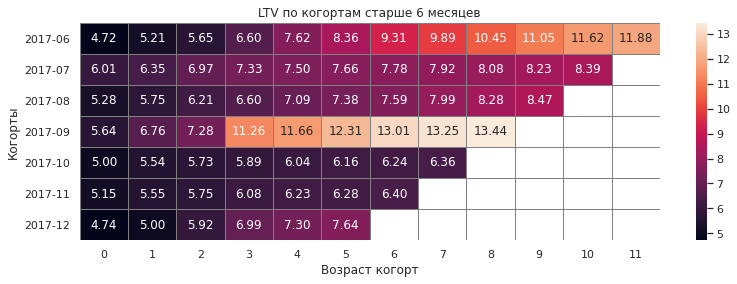

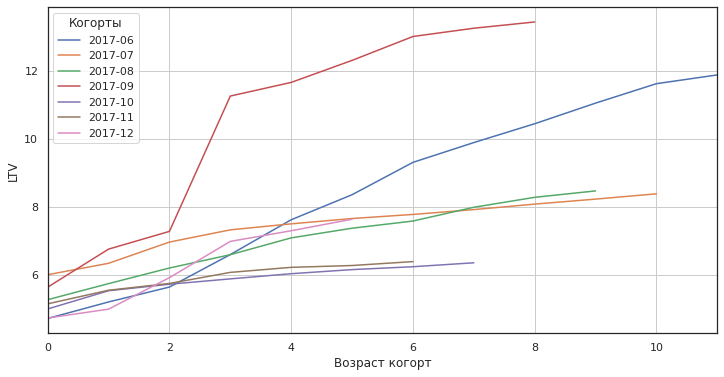

In [27]:

orders_log['orders_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_log['first_order_month'] = orders_log['first_buy_ts'].astype('datetime64[M]')

#находим общую выручку по месяцам и когортам
cohorts = (
    orders_log.groupby(['first_order_month', 'orders_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

cohorts['buy_month'] = [x[:7] for x in cohorts['first_order_month'].astype(str)]

#добавляем количество пользователей в когорте
report = pd.merge(cohort_sizes,cohorts,on='buy_month')

report = report.query('first_order_month <= "2017-12-01"')

#находим возраст когорты
report['age'] = (
    report['orders_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

display(report)

report['ltv'] = report['revenue'] / report['n_buyers']

output = report.pivot_table(
    index='buy_month', columns='age', values='ltv', aggfunc='mean'
).cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('LTV по когортам старше 6 месяцев')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Возраст когорт')
plt.ylabel('Когорты')
plt.show()


output.T.plot(kind='line',figsize=(12, 6))
plt.legend(title='Когорты')
plt.xlabel('Возраст когорт')
plt.grid(True)
plt.ylabel('LTV')
plt.show()

In [28]:
#находим средний LTV за 6 месяцев
display(output[5].mean().round(2))

7.97

Из графиков видно, что из всех выбивается с самым высоким LTV у сентябрьская когорта, несмотря на то, что есть три когорты старшее нее. Заказчику предлагается  проанализировать, какие действия были предприняты в сентябре, т.к. благодаря ним пользователи, совершившие покупку первый раз в этом месяце в дальнейшем покупают гораздо охотнее остальных пользователей.

Также неплохой показатель у июньской когорты, на 12 месяц LTV составил 11.88  

Самые плохие показатели у октябрьской и ноябрьской когорт (~6,4 у.е. на 7 и 6 месяцы соответсвенно)

В среднем, за 6 месяцев пользователи приносят 7,92 у.е.

#### Вывод

В среднем, через ~15 часов после первого посещения пользователь совершает покупку, причем за 6 месяцев после первого посещения сайта на пользователя в среднем приходится одна (1,07) покупка. 

Самый высокий средний чек в сентябре 2017 и равен ~9,3 у.е.С каждой новой когортой средний чек падает.

В среднем, за 6 месяцев пользователи приносят 7,92 у.е.

Средний чек за весь период составляется: 5,19 у.е

Самый высокий LTV у сентябрьской когорты - 13,44 у.е. (на 8-ой месяц)
Самые низкие LTV у октябрьской и ноябрьской когорт (~6,4 у.е. на 7 и 6 месяцы соответсвенно)

Исходя из полученных данных можно утверждать, что в сентябре были предприняты какие-то действия, которые крайне положительно сказались на настроении пользователя: средний чек существенно вырос, пользователи, который первый раз совершили покупку в сентябре покупают в дальнейшем охотнее остальных пользователей. Заказчику будет рекомендовано проанализировать рекламные кампании и программы лояльности, которые запускались в сентябре 2017 - судя по графикам и данным они самые эффективные.  

### Расчет маркетинговых метрик

Анализ маркетинговых метрик будем выполнять в разрезе источников. 

Пользователь мог заходить на сайт из нескольких источников. Очень важно, какое первое впечатление производит сайт - это напрямую влияет на последующие посещения и покупкию. К тому же бывает так, что пользователь пришел из одного источника, изучил сайт, посмотрел все что интересует и ушел думать, а потом вернулся на сайт из другого источника и совершил покупку. Поэтому за основной источник возьмем первый, с которого пользователь перешел на сайт.

Общая сумма расходов 329131.62 у.е.


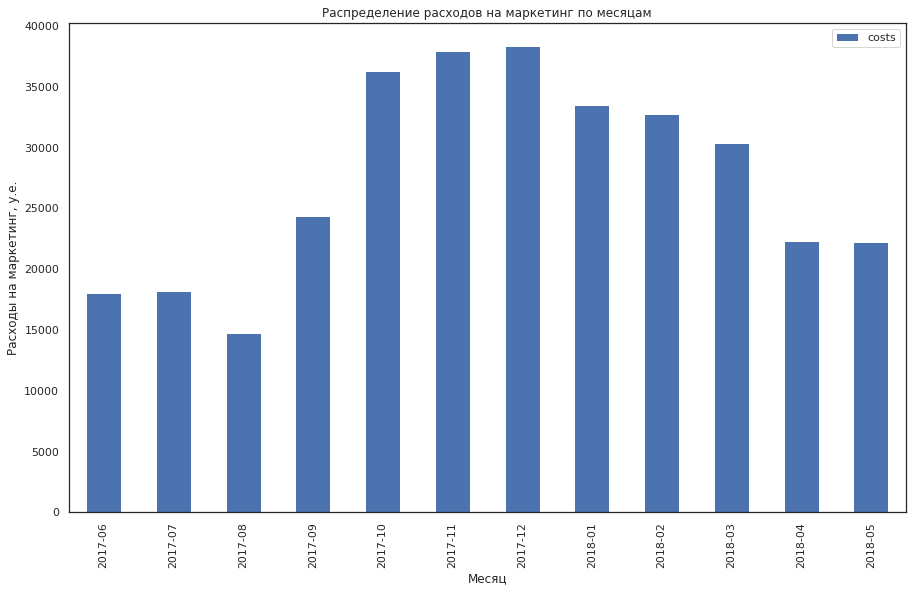

In [29]:
print('Общая сумма расходов',costs['costs'].sum(),'у.е.')
costs_by_month = costs.groupby('dt_month').agg({'costs':'sum'}).reset_index()
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
costs_by_month_and_source = costs.groupby(['source_id','dt_month']).agg({'costs':'sum'}).reset_index()

costs_by_month.plot(
    x = 'dt_month',
    y = 'costs',
    kind = 'bar',
    figsize = (15,9)
)
plt.title('Распределение расходов на маркетинг по месяцам')
plt.ylabel('Расходы на маркетинг, у.е.')
plt.xlabel('Месяц')
plt.show()


На графике "Распределение расходов на маркетинг по месяцам" видно, что самые большие расходы на маркетинг были с октября по декабрь 2017 (выше 35 000 у.е.). Стоит обратить внимание на резкое увеличение расходов на маркетинг в сентябре - это дополнительно указывает на то, что в сентябре действительно запускались маркетинговые компании, которые привели к изменениям, описанным в пункте 4.2.1


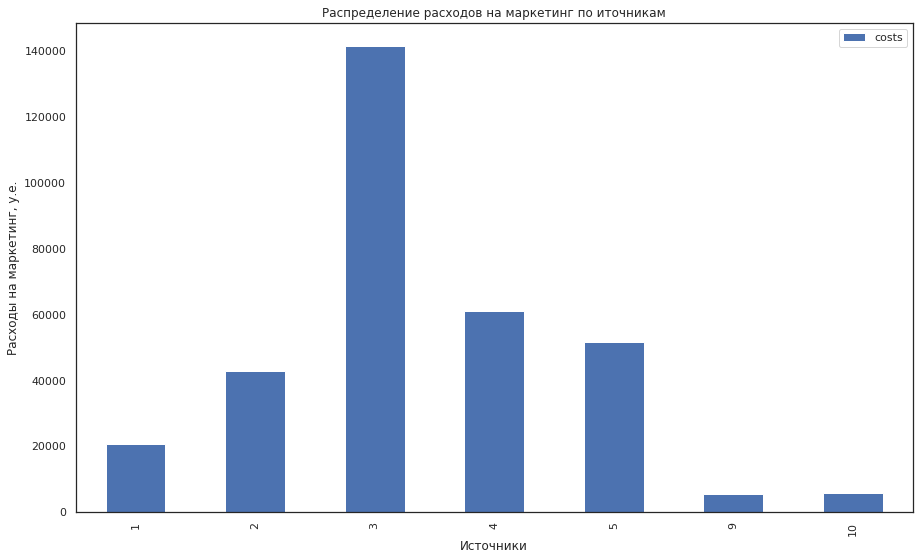

In [30]:
costs_by_source.plot(
    x = 'source_id',
    y = 'costs',
    kind = 'bar',
    figsize = (15,9)
)
plt.title('Распределение расходов на маркетинг по иточникам')
plt.ylabel('Расходы на маркетинг, у.е.')
plt.xlabel('Источники')
plt.show()

На графике "Распределение расходов на маркетинг по источникам" видно, что среди всех источников больше всего расходов приходится на источник 3 (141321 у.е.)

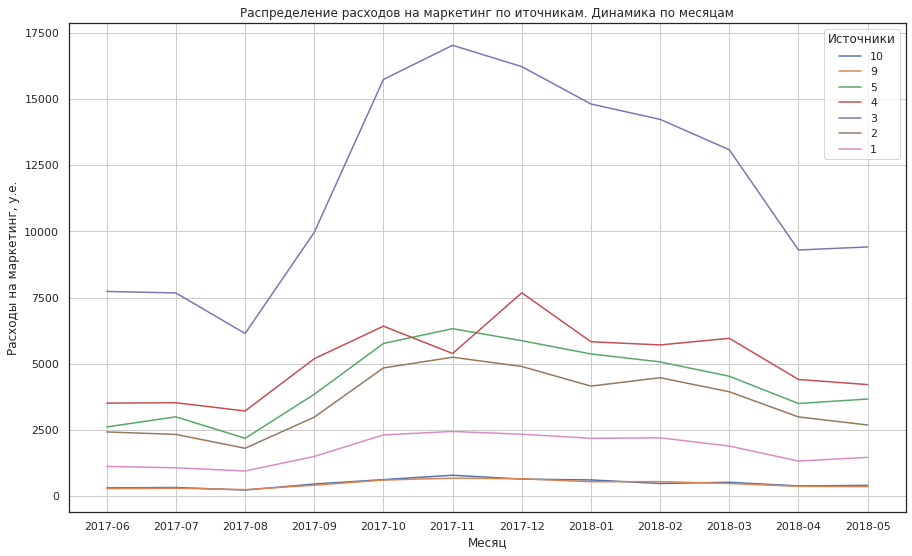

In [31]:
plt.figure(figsize=(15,9))  
for each in costs_by_month_and_source['source_id'].value_counts().index:
    plt.plot(
        costs_by_month_and_source.query('source_id == @each')['dt_month'],
        costs_by_month_and_source.query('source_id == @each')['costs']
    )
    plt.ylabel('Расходы на маркетинг, у.е.')
    plt.xlabel('Месяц')
    plt.legend(costs_by_month_and_source['source_id'].value_counts().index,title='Источники')
    plt.grid(True)
plt.title('Распределение расходов на маркетинг по иточникам. Динамика по месяцам')
plt.show()

Из графика "Распределение расходов на маркетинг по иточникам. Динамика по месяцам" видно, что для всех источников наблюдаетя рост расходов на маркетинг с августа 2017 до ноября 2017 года и далее плавное (относительно роста) снижение до апреля 2018. 

Посчитаем CAC (стоимость привлечения пользователя) в разрезе источников и рассмотрим изменение метрики во времени.
Для определения самого перспективного рекламного источника найдем средний CAC для каждого из них, а также найдем объем привлеченного трафика из каждого источника.

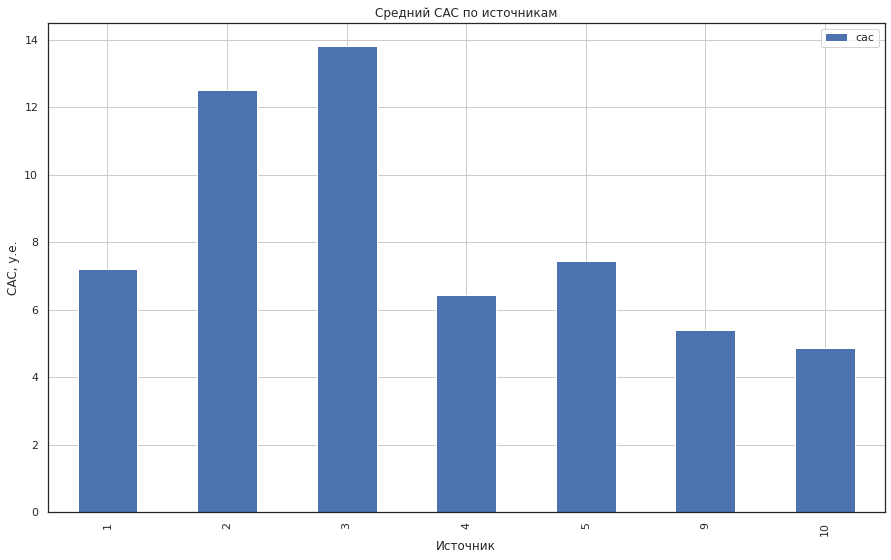

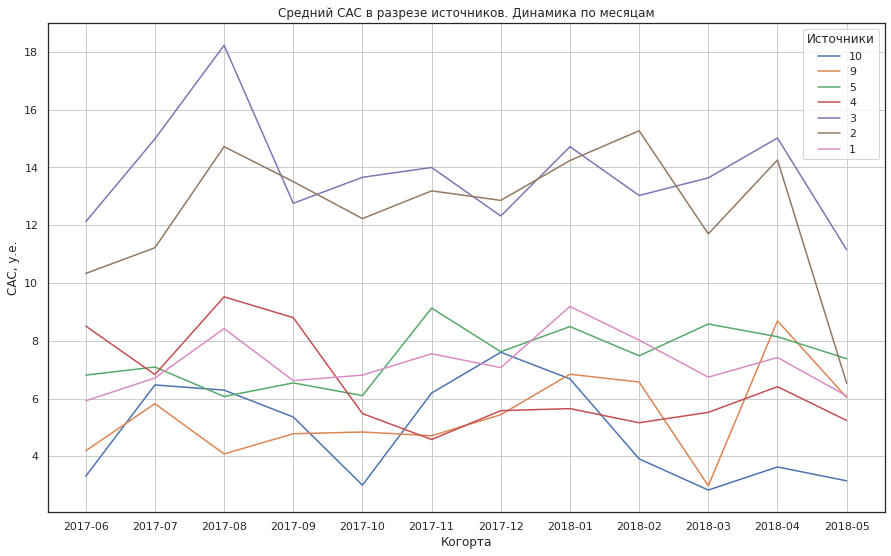

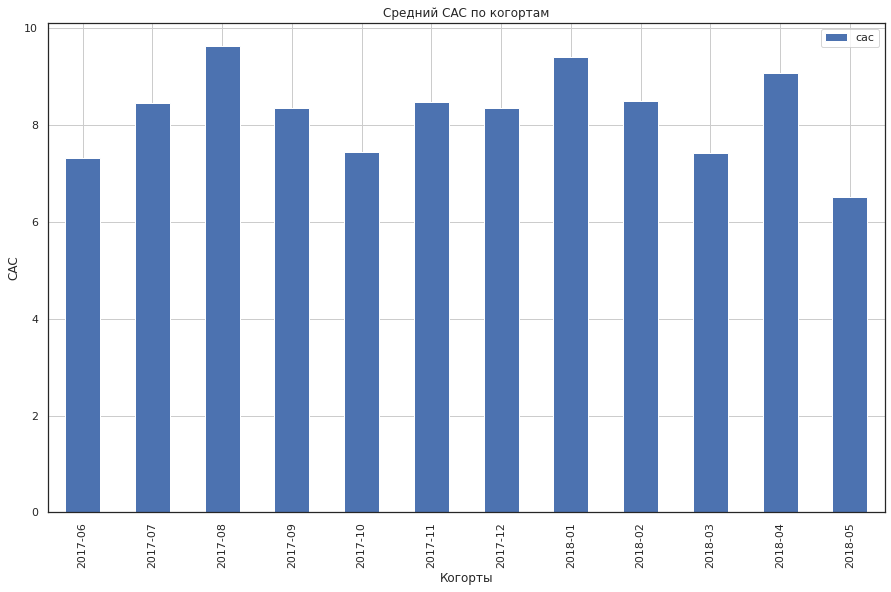

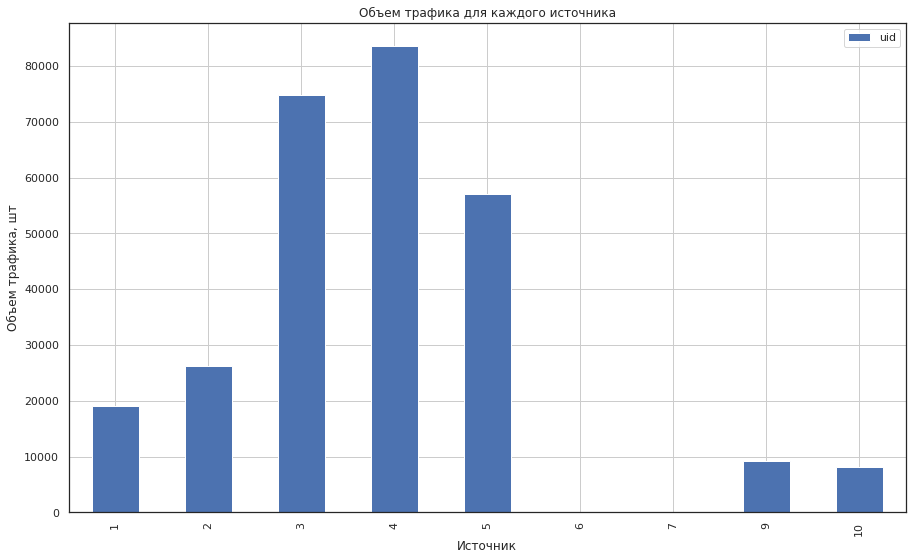

In [32]:
#display(costs_by_month_and_source)

#находим первый источник, на который зашел пользователь
first_buy_ts = first_buy_ts.reset_index()
first_source = visits_log.sort_values('start_ts').groupby('uid').first().reset_index()

#объединяем с месячными когортами по дате первой покупки
first_source_visits = pd.merge(first_source[['uid','source_id']],first_buy_ts,on='uid')
first_source_visits['dt_month'] = [x[:7] for x in first_source_visits['first_buy_ts'].astype(str)]

#находим количество пользователей для каждого источника по когортам и добавляем таблицу с расходами
first_source_num_users = first_source_visits.groupby(['source_id','dt_month']).agg({'uid':'count'}).reset_index()
cac_report = pd.merge(first_source_num_users,costs_by_month_and_source,on=['source_id','dt_month'])
cac_report['cac'] = (cac_report['costs'] / cac_report['uid']).round(2)

#формируем отчеты в разных аналитиках
average_source_month_cac_report = cac_report.groupby(['source_id','dt_month']).agg({'cac':'mean'}).reset_index()
average_month_cac_report = cac_report.groupby(['dt_month']).agg({'cac':'mean'}).reset_index()
average_source_cac_report = cac_report.groupby(['source_id']).agg({'cac':'mean'}).reset_index()



average_source_cac_report.plot(
    x = 'source_id',
    y = 'cac',
    kind = 'bar',
    figsize = (15,9),
    grid = True
)
plt.title('Средний CAC по источникам')
plt.ylabel('CAC, у.е.')
plt.xlabel('Источник')
plt.show()


plt.figure(figsize=(15,9))  
for each in average_source_month_cac_report['source_id'].value_counts().index:
    plt.plot(
        average_source_month_cac_report.query('source_id == @each')['dt_month'],
        average_source_month_cac_report.query('source_id == @each')['cac']
    )
    plt.ylabel('CAC, у.е.')
    plt.xlabel('Когорта')
    plt.grid(True)
    plt.legend(average_source_month_cac_report['source_id'].value_counts().index,title='Источники')
plt.title('Средний CAC в разрезе источников. Динамика по месяцам')
plt.show()

average_month_cac_report.plot(
    x = 'dt_month',
    y = 'cac',
    kind='bar',
    figsize=(15, 9) 
)
plt.title('Средний CAC по когортам')
plt.xlabel('Когорты')
plt.grid(True)
plt.ylabel('CAC')
plt.show()


visits_log.groupby('source_id').agg({'uid':'nunique'}).reset_index().plot(
    x = 'source_id',
    y = 'uid',
    kind='bar',
    figsize=(15, 9)
)
plt.title('Объем трафика для каждого источника')
plt.xlabel('Источник')
plt.grid(True)
plt.ylabel('Объем трафика, шт')
plt.show()


In [33]:
display(average_source_cac_report)

print()
print('Средний САС по всем источникам:')
print(cac_report['cac'].mean().round(2))


,source_id,cac
0,1,7.213333
1,2,12.505000
2,3,13.803333
3,4,6.440000
4,5,7.452500
5,9,5.415000
6,10,4.868333



Средний САС по всем источникам:
8.24


Из графика "Средний CAC по источникам" видно, что самый высокий CAC у источника под номером 3 и равен 13,8 у.е. Но и из этого источника приходит довольно большой объем трафика (~74000 за весь период).

Минимальный САС у 10 источника и он равен 4,87 у.е., причем трафика из этого источника очень мало (менее 10000 за весь период).

Очень высокий САС у источника 2 (12,5 у.е.). В совокупности с  малым объемом привлеченного трафика (~26000 за весь период) это делает источник 2, предположительно, одним из самых невыгодных источников.

Предположительно, самый выгодным источником может оказаться источник 4, т.к. у него относительно невысокий CAC (6,44 у.е.) и самый большой объем трафика (~83000 за весь период). Также один из самых выгодных источников может являться 5 с САС 7,42 у.е. и объемом трафика ~56000.


Из графика "Средний CAC в разрезе источников. Динамика по месяцам" можно увидеть интересную закономерность - при увеличении расходов на маркетинг САС пользователей в соответсвующем расходам месяце снижается и наоборот. 

Средний САС пользователей равен 8,24 у.е

Для формулирования более точных выводов недостаточно знать САС, нужно понимать, сколько приносят денег пользователи и как быстро окупаются затраты на привлечение пользователей, поэтому посчитаем ROMI  (по упрощенной формулен) на 6-ой месяц в разрезе источников и когорт. 6-й месяц взяли не случайно, т.к. ранее именно на этот месяц мы рассчитали САС, который необходим для подсчета ROMI

,ltv,source_id,cac,romi
0,12.01,1,7.213333,1.664972
1,15.49,2,12.505000,1.238705
2,5.73,3,13.803333,0.415117
3,6.03,4,6.440000,0.936335
4,9.35,5,7.452500,1.254613
5,5.82,9,5.415000,1.074792
6,3.93,10,4.868333,0.807258


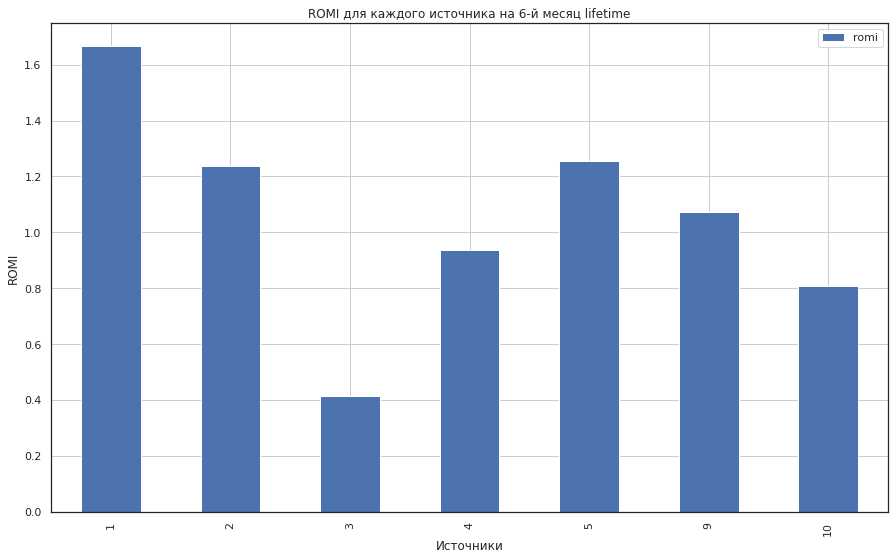

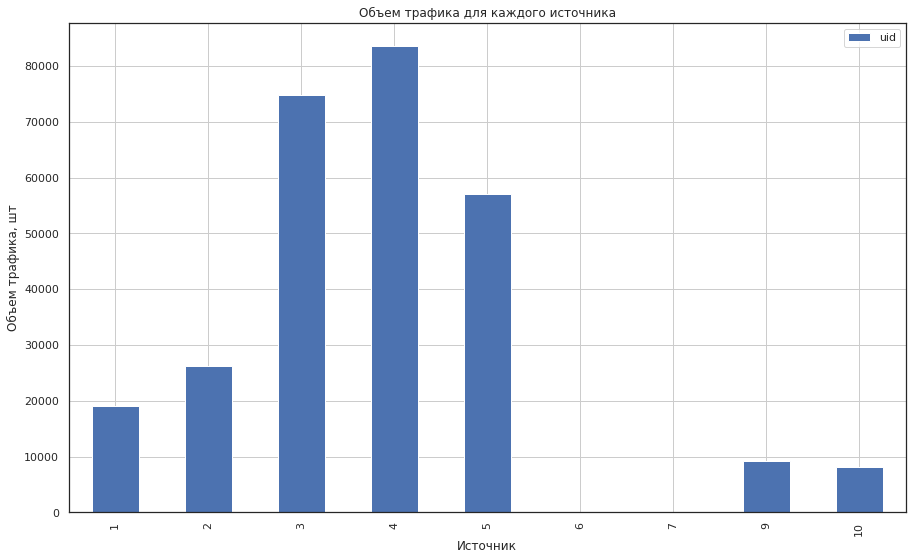

In [34]:

orders_first_source = pd.merge(
    first_source[['uid','device','source_id','session_date']],
    orders_log[['revenue','uid','buy_month','orders_month','first_order_month']],on = 'uid'
)

ltv_frames = ['ltv1','ltv2','ltv3','ltv4','ltv5','ltv9','ltv10']

for each in orders_first_source['source_id'].value_counts().index:
    
        data = orders_first_source.query('source_id == @each and first_order_month <= "2017-12-01"')
        cohort_size_sources = data.groupby(
            ['first_order_month']
           ).agg({'uid': 'nunique'}).reset_index()
        
        cohort_revenue_sources = data.groupby(
            ['first_order_month','orders_month']
            ).agg({'revenue':'sum'}).reset_index()
        
        data = pd.merge(cohort_size_sources,cohort_revenue_sources,on = 'first_order_month')
        data['age'] = (
            data['orders_month'] - data['first_order_month']
            ) / np.timedelta64(1, 'M')
        data['age'] = data['age'].round().astype('int')
        
        data = data.query('first_order_month <= "2017-12-01"')
        data['ltv'] = data['revenue'] / data['uid']
        try:
            setattr(__main__, 'ltv{}'.format(each),data.pivot_table(
                index='first_order_month', columns='age', values='ltv', aggfunc='mean'
                ).cumsum(axis=1)[5].mean().round(2)
            )
        except:
            pass
        
ltv_vector = []        
for each in ltv_frames:     
    ltv_vector.append(eval(each))    
ltv_vector = pd.DataFrame(ltv_vector)

romi_report = ltv_vector.join(average_source_cac_report)
romi_report.columns = ['ltv','source_id','cac']
romi_report['romi'] = romi_report['ltv']/romi_report['cac']

display(romi_report)

romi_report.plot(
    x = 'source_id',
    y = 'romi',
    kind='bar',
    figsize=(15, 9) 
)
plt.title('ROMI для каждого источника на 6-й месяц lifetime')
plt.xlabel('Источники')
plt.grid(True)
plt.ylabel('ROMI')
plt.show()


visits_log.groupby('source_id').agg({'uid':'nunique'}).reset_index().plot(
    x = 'source_id',
    y = 'uid',
    kind='bar',
    figsize=(15, 9)
)
plt.title('Объем трафика для каждого источника')
plt.xlabel('Источник')
plt.grid(True)
plt.ylabel('Объем трафика, шт')
plt.show()


Исходя из графиков объема трафика и ROMI для источников можно утверждать:

На 6-й месяц окупился трафик, пришедший из источников 1,5,2,9.

Самый выгодный источник для компании - 1. Несмотря на небольшой объем трафика, затраты на привлечение окупились на 6-месяц и ROMI равен 1,66 (затраты на маркетинг приносят 66% прибыли). Рекомендуется увеличить расходы на рекламную кампанию по данному источнику - это принесет больше денег компании. 

На втором месте по выгоде для компании находится источник 5, на 6-й месяц ROMI равен 1,25 (затраты на маркетинг приносят 25% прибыли). Также из этого источника приходит более чем в 3 раза трафика, относительно первого источника. Также рекомендуется увеличить расходы на рекламную компанию по данному источнику.

На третьем месте источник 2 с ROMI 1,23 (затраты на маркетинг приносят 23% прибыли). Затраты на маркетинг по этому источнику рекомендуется оставить прежними. Таким образом можно убедиться, что выводы на основанни только САС делать нельзя. 

Источник 9 не попадает в список приоритетных, т.к. на 6-й месяц его ROMI составил 1,07 (затраты на маркетинг приносят всего 7% прибыли), что сильно меньше относительно первых трех источников.

Самый невыгодный источник - 3. Его ROMI на 6-й месяц составил 0,41 (осталось окупить 59% затрат). Рекомендуется отказаться от затрат на этот рекламный источник и распределить освобожденные финансы на 1 источник (80% от суммы) и на 5 источник (20% от суммы). 

Также рекомендуется снизить затраты на маркетинг по 4 источнику и распределить их на рекламную кампанию по источнику 5. 

Дополнительно можно отказаться от источника 10, т.к. на 6-й месяц затраты все еще не окупились (ROMI 0,8) и трафик из этого источника очень маленький (за весь период менее 10 000 тыс). 

#### Вывод

Общая сумма расходов на маркетинг за весь период составила: 329132 у.е.

Самые большие расходы на маркетинг были с октября по декабрь 2017 (выше 35 000 у.е.).

Среди всех источников больше всего расходов приходится на источник 3 (141321 у.е. за все время)

Для всех источников наблюдаетя рост расходов на маркетинг с августа 2017 до ноября 2017 года и далее плавное (относительно роста) снижение до апреля 2018. 

Самый высокий CAC у источника под номером 3 и равен 13,8 у.е. Из этого источника приходит довольно большой объем трафика (~74000 за весь период).

Очень высокий САС у источника 2 (12,5 у.е.). Трафика из этого источника не много (~26000 за весь период) 

Минимальный САС у 10 источника и он равен 4,87 у.е. Трафика из этого источника очень мало (менее 10000 за весь период).

Средний САС пользователя равен 8,24 у.е

На 6-й месяц окупились расходы на привлечение пользователей, которые пришли из источников 1,5,2,9.

Самый выгодный источник для компании - 1. Несмотря на небольшой объем трафика, затраты на привлечение окупились на 6-месяц и ROMI равен 1,66 (затраты на маркетинг приносят 66% прибыли). Рекомендуется увеличить расходы на рекламную кампанию по данному источнику - это принесет больше денег компании. На втором месте по выгоде для компании находится источник 5, на 6-й месяц ROMI равен 1,25 (затраты на маркетинг приносят 25% прибыли). Из этого источника приходит более чем в 3 раза трафика, относительно первого источника. Рекомендуется увеличить расходы на рекламную компанию по данному источнику. На третьем месте источник 2 с ROMI 1,23 (затраты на маркетинг приносят 23% прибыли). Затраты на маркетинг по этому источнику рекомендуется оставить прежними. 

Самый невыгодный источник - 3. Его ROMI на 6-й месяц составил 0,41 (осталось окупить 59% затрат). Рекомендуется отказаться от затрат на этот рекламный источник и распределить освобожденные финансы на 1 источник (80% от суммы) и на 5 источник (20% от суммы). 

Также рекомендуется снизить затраты на маркетинг по 4 источнику и распределить их на рекламную кампанию по источнику 5. 

Дополнительно можно отказаться от источника 10, т.к. на 6-й месяц затраты все еще не окупились (ROMI 0,8) и трафик из этого источника очень маленький (за весь период менее 10 000 тыс). 

## Итоговый вывод

<b>- Как клиенты пользуются сервисом?</b>

Исходя из полученных данных по рассчитанным метрикам есть два варианта для оценки ситуации:

1) С сайтом что-то не так: несмотря на хорошие показатели посещаемости сайта (среднее количество уникальных пользователей в день равно 908, в неделю 5717, в месяц 23229) пользователи в среднем проводят на сайте всего по 1 минуте и, обычно, заходят на сайт не более 1 раза в день; из всех пользователей за месяц, в среднем, всего лишь 5,9% или 1240 пользователей возвращаются на сайт на следующий месяц. Рекомендуется выполнить анализ и разработать необходимые меры для увеличения возврата пользователей и , возможно, увеличение длительности сессии. 

2) Что-то не так с определением uid пользователей. Например, идентификаторы сбрасываются при каком-то условии и тогда у нас завышены показатели посещаемости, но Retention Rate может быть больше. Рекомендуется обратиться к разработчикам компании для проверки корректности присвоения "uid" пользователям.

<b>- Когда клиенты делают первые покупки на сайте?</b>

В среднем, через ~15 часов после первого посещения пользователь совершает покупку, причем за 6 месяцев после первого посещения сайта на пользователя в среднем приходится одна (1,07) покупка.

<b>- Сколько денег приносит компании каждый клиент?</b>

В среднем, за 6 месяцев пользователи приносят 7,92 у.е.  

Средний чек за весь период составляется: 5,19 у.е

Самый высокий LTV у сентябрьской когорты - 13,44 у.е. (на 8 месяц). Самые плохие показатели у октябрьской и ноябрьской когорт (~6,4 у.е. на 7 и 6 месяцы соответсвенно)

Самый высокий средний чек был в сентябре 2017 и равен ~9,3 у.е. С каждой новой когортой средний чек падает.

<b>- Когда расходы на привлечение клиента окупаются?</b>

Средняя стоимость привлечения клиента составляет: 8,24 у.е.

Самый высокий CAC у источника под номером 3 и равен 13,8 у.е.Минимальный САС у 10 источника - 4,87 у.е.

Из 7-ми источников, на которые были распределены затраты на маркетинг на 6 месяц окупились 1,2,5,9 источники (ROMI > 1). Практически окупился 4 источник (ROMI = 0.93). Не окупились 10 и 3 источники (ROMI 0.8 и 0.41 соотвественно).

<b>- На какие источники трафика стоит делать упор в рекламной кампании?</b>

Самый выгодный источник для компании - 1. Несмотря на небольшой объем трафика, затраты на привлечение окупились на 6-месяц и ROMI равен 1,66 (затраты на маркетинг приносят 66% прибыли). Рекомендуется увеличить расходы на рекламную кампанию по данному источнику - это принесет больше денег компании. 

На втором месте по выгоде для компании находится источник 5, на 6-й месяц ROMI равен 1,25 (затраты на маркетинг приносят 25% прибыли). Также из этого источника приходит более чем в 3 раза трафика, относительно первого источника. Также рекомендуется увеличить расходы на рекламную компанию по данному источнику.

На третьем месте источник 2 с ROMI 1,23 (затраты на маркетинг приносят 23% прибыли). Однако, учитывая  Затраты на маркетинг по этому источнику рекомендуется оставить прежними.

<b>- От каких источников трафика можно отказаться?</b>

Самый невыгодный источник - 3. Его ROMI на 6-й месяц составил 0,41 (осталось окупить 59% затрат). Рекомендуется отказаться от затрат на этот рекламный источник и распределить освобожденные финансы на 1 источник (80% от суммы) и на 5 источник (20% от суммы). 

Также рекомендуется снизить затраты на маркетинг по 4 источнику и распределить их на рекламную кампанию по источнику 5. 

Дополнительно можно отказаться от источника 10, т.к. на 6-й месяц затраты все еще не окупились (ROMI 0,8) и трафик из этого источника очень маленький (за весь период менее 10 000 тыс). 

<b>- Какие клиенты наиболее выгодны для компании ?</b>

Исходя из имеющихся данных:
Самые выгодные клиенты  - клиенты из когорт 06.2017 и 09.2021, пришедшие из источников 1,5,2 и, вероятно, по рекламным кампаниям, схожим с кампаниями проводимыми в сентябре  2017 года.

Рекомендуется проанализировать рекламные кампании, запущенные в сентябре т.к. их запуск крайне положительно сказался на настроении пользователей: средний чек существенно вырос, пользователи, который первый раз совершили покупку в сентябре покупают в дальнейшем охотнее остальных пользователей.